In [1]:
#Import required packages

import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import matplotlib.pyplot as plt
import os

import torch
import torch.nn as nn
import torch.optim as optim

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.0.1+cu118


In [2]:
!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 62.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
import torch_geometric.data as data_class
import torch_geometric.transforms as transforms
import torch_geometric.nn as pyg_nn
from torch_geometric.data import Data

In [4]:
# Artificial data settings:-
# i) Created 500 nodes
# ii) Randomly initialised 5 time series data with 10 time steps for each nodes with random noise
# iii) Randomly initialised 3 scalar valued features for each nodes
# iv) Randomly made edges between nodes with 0.1 probability
# v) Calculated the target variable for each node following below logic and expecting neural network to learn it:-
"""
if neighbors:
    sine_weighted_sum = sum(G[node][n]["weight"] * np.sin(G.nodes[n]["simple_features"][0]) for n in neighbors)
    cosine_time_series_mean = np.cos(np.mean(G.nodes[node]["time_series_data"][0]))
    sqrt_simple_feature = np.sqrt(np.abs(G.nodes[node]["simple_features"][1]))

    target_variable = 0.4 * sine_weighted_sum + 0.4 * cosine_time_series_mean + 0.2 * sqrt_simple_feature
else:
    target_variable = np.cos(np.mean(G.nodes[node]["time_series_data"][0])) + 0.2 *
                      np.sqrt(G.nodes[node]["simple_features"][1])



G.nodes[node]["target_variable"] = target_variable + np.random.normal(0,0.1)
"""

'\nif neighbors:\n    sine_weighted_sum = sum(G[node][n]["weight"] * np.sin(G.nodes[n]["simple_features"][0]) for n in neighbors)\n    cosine_time_series_mean = np.cos(np.mean(G.nodes[node]["time_series_data"][0]))\n    sqrt_simple_feature = np.sqrt(np.abs(G.nodes[node]["simple_features"][1]))\n\n    target_variable = 0.4 * sine_weighted_sum + 0.4 * cosine_time_series_mean + 0.2 * sqrt_simple_feature\nelse:\n    target_variable = np.cos(np.mean(G.nodes[node]["time_series_data"][0])) + 0.2 * \n                      np.sqrt(G.nodes[node]["simple_features"][1])\n\n \n\nG.nodes[node]["target_variable"] = target_variable + np.random.normal(0,0.1)\n'

Node 0:
  Time series data: [[ 0.4224154   0.17720413  0.50793651 -0.03418452  0.83963816  0.64419058
   0.68292516  0.49484627  0.1139978   0.54912427]
 [ 0.56153269  0.75455156  0.299111    0.49942741 -0.09982782  0.19400329
   0.68132824  0.78368827  0.47789832 -0.09321685]
 [ 0.86116585  0.19764813  0.61232929  0.91665477 -0.00251612  0.04596811
   0.31050281  0.48490682  0.77353299  0.09698952]
 [ 0.4909371   0.26809015  0.53761571  0.84301315  0.59789517  0.52081267
   1.00769704  0.42349848  0.69487763  0.45010263]
 [ 0.41805824  0.89068682  0.99464109  0.49932839  0.45350395  1.01003905
   0.42137209  1.00511879  0.56840616  0.22358234]]
  Simple features: [0.19164631 0.91545159 0.53841736]
  Target variable: 6.461840717129482

Node 1:
  Time series data: [[ 0.14581761  0.16443623  0.75746556  0.08372581  0.94305375  0.83513478
   0.41078169  0.04314855  0.71075085  0.47087606]
 [ 0.73073875  0.18138315  0.16586906  0.50733827 -0.02175819  0.68331711
   0.72348051  0.16074653  

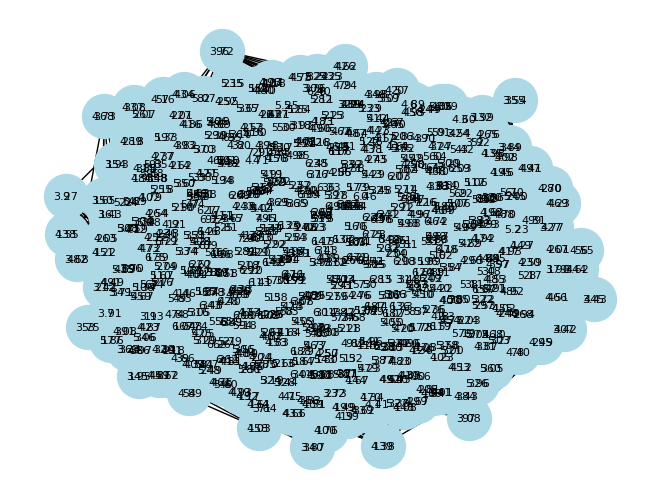

In [5]:
def add_gaussian_noise(data, mean=0, std_dev=0.1):
    noise = np.random.normal(mean, std_dev, data.shape)
    return data + noise

# Configuration
num_nodes = 500
num_time_series = 5
num_time_steps = 10
num_simple_features = 3

# Generate random time series data for each node
time_series_data = np.random.rand(num_nodes, num_time_series, num_time_steps)
time_series_data = add_gaussian_noise(time_series_data)

# Generate random simple features for each node
simple_features = np.random.rand(num_nodes, num_simple_features)
simple_features = add_gaussian_noise(simple_features)

# Create a random graph connecting nodes
G = nx.gnp_random_graph(num_nodes, 0.1)

# Add node features
for i in range(num_nodes):
    G.nodes[i]["time_series_data"] = time_series_data[i]
    G.nodes[i]["simple_features"] = simple_features[i]

# Add edge weights
for u, v in G.edges():
    G[u][v]["weight"] = random.random()

# Create target variables based on neighbors and time series data
for node in G.nodes:
    neighbors = list(G.neighbors(node))
    if neighbors:
        sine_weighted_sum = sum(G[node][n]["weight"] * np.sin(G.nodes[n]["simple_features"][0]) for n in neighbors)
        cosine_time_series_mean = np.cos(np.mean(G.nodes[node]["time_series_data"][0]))
        sqrt_simple_feature = np.sqrt(np.abs(G.nodes[node]["simple_features"][1]))



        target_variable = 0.4 * sine_weighted_sum + 0.4 * cosine_time_series_mean + 0.2 * sqrt_simple_feature
    else:
        target_variable = np.cos(np.mean(G.nodes[node]["time_series_data"][0])) + 0.2 * np.sqrt(G.nodes[node]["simple_features"][1])



    G.nodes[node]["target_variable"] = target_variable + np.random.normal(0,0.1)

# Print the generated data
for i, data in G.nodes(data=True):
    if(i==5):
        break
    print(f"Node {i}:")
    print(f"  Time series data: {data['time_series_data']}")
    print(f"  Simple features: {data['simple_features']}")
    print(f"  Target variable: {data['target_variable']}")
    print()

def visualize_graph(G):
    pos = nx.spring_layout(G, seed=42)  # Position nodes using the spring layout algorithm
    nx.draw(G, pos, with_labels=True, node_size=1000, node_color='lightblue', font_size=8)

    # Optionally, you can display the target variables as labels
    labels = {i: f"{data['target_variable']:.2f}" for i, data in G.nodes(data=True)}
    nx.draw_networkx_labels(G, pos, labels, font_size=8)

visualize_graph(G)
plt.show()

In [6]:
##Create pytorch geometric graph object so that it can be used with Graph Convolution Network
# 1. Get the list of nodes and edges from the NetworkX graph
nodes = list(G.nodes())
edges = list(G.edges())

# 2. Convert nodes to a dictionary for indexing
node_index_map = {node: i for i, node in enumerate(nodes)}

# 3. Create an edge index tensor with bidirectional edges
edge_index = [[node_index_map[edge[0]], node_index_map[edge[1]]] for edge in edges]  # Original edges
edge_index += [[node_index_map[edge[1]], node_index_map[edge[0]]] for edge in edges]  # Reversed edges
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()

# 4. Convert node features to a tensor
node_features = torch.tensor([G.nodes[node]['simple_features'] for node in nodes], dtype=torch.float)

# 5. Convert node time series features to a tensor
ts_features = torch.tensor([G.nodes[node]['time_series_data'] for node in nodes], dtype=torch.float)
ts_features = ts_features.permute(0, 2, 1) #pytorch geometric expects (num_nodes, seq_length, num_timeseries)

#6. Convert target to a tensor
target = torch.tensor([G.nodes[node]['target_variable'] for node in nodes], dtype=torch.float)

#7. EDge weights to a tensor
edge_weights = [G.edges[edge]['weight'] for edge in edges]  # Original edge weights
edge_weights += edge_weights  # Reversed edge weights (duplicated for undirected graph)
edge_attr = torch.tensor(edge_weights, dtype=torch.float)

<ipython-input-6-435b99e1e35b>:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  node_features = torch.tensor([G.nodes[node]['simple_features'] for node in nodes], dtype=torch.float)


In [7]:
graph = data_class.Data(x=node_features, edge_index=edge_index, ts_data=ts_features, y=target, edge_weight=edge_attr)
graph

Data(x=[500, 3], edge_index=[2, 24924], y=[500], ts_data=[500, 10, 5], edge_weight=[24924])

In [8]:
##Add train, test and validation mask, 70, 15, 15 split
num_nodes = graph.num_nodes

# Generate indices for the train, validation, and test sets
train_ratio, val_ratio = 0.7, 0.15
train_size = int(train_ratio * num_nodes)
val_size = int(val_ratio * num_nodes)

indices = torch.randperm(num_nodes)
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

In [9]:
## Creating model architecture
class GNNModel(torch.nn.Module):
    def __init__(self, lstm_hidden_size, gnn_hidden_size, num_scalar_features, num_time_series, num_layers=2):
        super(GNNModel, self).__init__()
        self.lstm_hidden_size = lstm_hidden_size
        self.gnn_hidden_size = gnn_hidden_size
        self.num_scalar_features = num_scalar_features
        self.num_time_series = num_time_series

        # LSTM for multivariate time series data
        self.lstm = nn.LSTM(input_size=num_time_series, hidden_size=lstm_hidden_size, num_layers=num_layers, batch_first=True)

        # Fully connected layer to concatenate LSTM output with scalar features
        self.fc = nn.Linear(lstm_hidden_size + num_scalar_features, gnn_hidden_size)

        # Graph convolution layers
        self.conv1 = pyg_nn.GCNConv(gnn_hidden_size, gnn_hidden_size)
        self.conv2 = pyg_nn.GCNConv(gnn_hidden_size, 1)

    def forward(self, x, time_series_data, edge_index, edge_weight):
        # Apply LSTM on multivariate time series data
        lstm_out, _ = self.lstm(time_series_data)
        lstm_out = lstm_out[:, -1, :]

        # Concatenate LSTM output with scalar features
        x = torch.cat((x, lstm_out), dim=1)

        # Pass the concatenated data through the fully connected layer
        x = self.fc(x)

        # Pass the features through graph convolution layers
        x = torch.relu(self.conv1(x, edge_index, edge_weight))
        x = self.conv2(x, edge_index, edge_weight)
        return x.squeeze(-1) #making the shape to be (num_nodes,1), squeezing last dimension

In [10]:
## Initialising GPU devices, shifting data and model to it
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GNNModel(lstm_hidden_size=32, gnn_hidden_size=64, num_scalar_features=node_features.shape[1], num_time_series=num_time_series).to(device)
graph = graph.to(device)
model=model.to(device)

In [11]:
#training loop, initialising optimiser and loss function
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_fn = nn.MSELoss()
train_losses = []
val_losses = []

num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()

    # Forward pass for train set
    out = model(graph.x, graph.ts_data, graph.edge_index, graph.edge_weight)
    train_loss = loss_fn(out[train_indices], graph.y[train_indices])

    # Backward pass
    train_loss.backward()
    optimizer.step()

    # Validation
    model.eval()
    with torch.no_grad():
        val_loss = loss_fn(out[val_indices], graph.y[val_indices])

    print(f"Epoch: {epoch}, Train Loss: {train_loss.item()}, Validation Loss: {val_loss.item()}")

    # Save the train and validation losses
    train_losses.append(train_loss.item())
    val_losses.append(val_loss.item())

Epoch: 0, Train Loss: 26.175491333007812, Validation Loss: 28.262582778930664
Epoch: 1, Train Loss: 20.433189392089844, Validation Loss: 22.172983169555664
Epoch: 2, Train Loss: 13.559235572814941, Validation Loss: 14.857205390930176
Epoch: 3, Train Loss: 4.662671089172363, Validation Loss: 5.292908191680908
Epoch: 4, Train Loss: 1.6612768173217773, Validation Loss: 1.5093454122543335
Epoch: 5, Train Loss: 4.163210391998291, Validation Loss: 3.9490463733673096
Epoch: 6, Train Loss: 0.6915279626846313, Validation Loss: 0.607722282409668
Epoch: 7, Train Loss: 0.5508987903594971, Validation Loss: 0.7002801895141602
Epoch: 8, Train Loss: 1.474890947341919, Validation Loss: 1.7789937257766724
Epoch: 9, Train Loss: 1.658707618713379, Validation Loss: 1.987481713294983
Epoch: 10, Train Loss: 1.1619592905044556, Validation Loss: 1.4230022430419922
Epoch: 11, Train Loss: 0.5239586234092712, Validation Loss: 0.6681377291679382
Epoch: 12, Train Loss: 0.2800820469856262, Validation Loss: 0.3010196

In [12]:
#performance on test set
model.eval()
with torch.no_grad():
    out = model(graph.x, graph.ts_data, graph.edge_index, graph.edge_weight)
    test_loss = loss_fn(out[test_indices], graph.y[test_indices])
print(f"Test Loss: {test_loss.item()}")

Test Loss: 0.2463885098695755


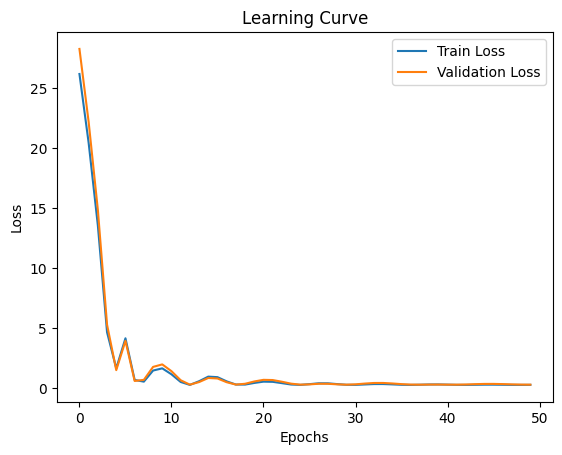

In [13]:
#plotting the learning curve
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Learning Curve")
plt.show()